Per funzionare, il presente notebook ha bisogno della cartella contenente i dati. <br> <br>
Dataset originale: <br>
https://github.com/vkaya24100/Different-Weapon-Types-datasets <br>
E' possibile importarli semplicemente aggiungendo una scorciatoia al proprio Drive per la seguente cartella: <br>
**https://drive.google.com/drive/folders/1m3muJ_peOKJkbCx-08ixRADQnrfaId0i?usp=sharing**

In [32]:
import pandas as pd
import numpy as np
import zipfile
import os
from google.colab import drive
from shutil import copyfile, rmtree
import random
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.preprocessing import image as kimage
import joblib
import seaborn as sns
from keras.utils import load_img as kimage2
plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['grid.alpha']=0

## CREAZIONE PERCORSO CORRETTO

In [2]:
drive.mount('/content/gdrive')
copyfile('gdrive/MyDrive/Data_DigitalSignalsProject/image.zip', 'image.zip')
zip = zipfile.ZipFile('image.zip')
zip.extractall()

Mounted at /content/gdrive


In [3]:
# Creo una nuova cartella image_split dentro alla quale divido le immagini per train e test set (0.75 - 0.25)

classes = os.listdir('image')

os.mkdir('image_split')
os.mkdir('image_split/train')
os.mkdir('image_split/test')

for name in classes:
  os.mkdir(f'image_split/train/{name}')
  os.mkdir(f'image_split/test/{name}')

  random.seed(123)
  train_idx = random.sample(range(len(os.listdir(f'image/{name}'))), int(len(os.listdir(f'image/{name}'))*0.75))

  for idx in range(len(os.listdir(f'image/{name}'))):
    if idx in train_idx:
      copyfile(  f"image/{name}/{os.listdir(f'image/{name}')[idx]}" ,  f"image_split/train/{name}/{os.listdir(f'image/{name}')[idx]}")
    else:
      copyfile(  f"image/{name}/{os.listdir(f'image/{name}')[idx]}" ,  f"image_split/test/{name}/{os.listdir(f'image/{name}')[idx]}")


## FUNZIONI 

In [4]:
# L'immagine viene portata alla dimensione 224x224 senza modificare le proporzioni

def resize_image(image, dim=224):
  (h, w) = image.shape

  if h == w:
    resized = cv2.resize(image, [dim,dim])

  elif h<w:
    diff = w-h
    squared = np.concatenate((image, np.zeros((diff, w))+255) ,axis=0)
    resized = cv2.resize(squared, [dim,dim])

  elif h>w:
    diff = h-w
    squared = np.concatenate((image, np.zeros((h, diff))+255) ,axis=1)
    resized = cv2.resize(squared, [dim,dim])

  return resized

In [5]:
# L'immagine viene centrata, sfruttando l'informazione che tutti gli sfondi sono perfettamente bianchi

def center_image(img, resize=True):
  if resize==True:
    img = resize_image(img)

  up = 0
  down = 0
  left = 0
  right = 0


  for row in range(224):
    if all((img[row,:])==255):
      up = up+1
    else:
      break

  for row in range(224):
    if all((img[-row-1,:])==255):
      down = down+1
    else:
      break

  for col in range(224):
    if all((img[:,col])==255):
      left = left+1
    else:
      break

  for col in range(224):
    if all((img[:,-col-1])==255):
      right = right+1
    else:
      break
  if up!=down:
    if up>down:
      diff = up-down
      img = np.concatenate((img[int(diff/2):,:], np.zeros((int(diff/2), 224))+255),axis=0)

    elif up<down:
      diff = down-up+1
      img = np.concatenate((np.zeros((int(diff/2), 224))+255, img[:-int(diff/2),:]),axis=0)
  if left!=right:
    if left>right:
      diff = left-right
      img = np.concatenate((img[:,int(diff/2):], np.zeros((224, int(diff/2)))+255),axis=1)

    elif left<right:
      diff = right-left+1
      img = np.concatenate((np.zeros((224, int(diff/2)))+255,  img[:,:-int(diff/2)] ),axis=1)

  return img


In [6]:
# Il centramento dell'immagine viene effettuato su tutti e tre i canali colore

def center_image_rgb(img):
  c0 = center_image(img[:,:,0])
  c1 = center_image(img[:,:,1])
  c2 = center_image(img[:,:,2])
  final = np.stack((c0,c1,c2), axis=2).astype(int)
  return final

In [7]:
# Rotazione dell'immagine

def rotate_image(img, angle):
  (h, w) = img.shape[:2]
  (cX, cY) = (w // 2, h // 2)

  M = cv2.getRotationMatrix2D((cX, cY), angle, 1)
  c0 = cv2.warpAffine(img[:,:,0], M, (w, h), borderValue=255.) 
  c1 = cv2.warpAffine(img[:,:,1], M, (w, h), borderValue=255.) 
  c2 = cv2.warpAffine(img[:,:,2], M, (w, h), borderValue=255.)

  rotated = np.stack((c0,c1,c2), axis=2).astype(int)
  return rotated

In [8]:
# Modifica della luminanza

def change_luminance(img, luminance_lim = 10):
  luminance_array = np.repeat(np.random.randint(-abs(luminance_lim), abs(luminance_lim)), 224 * 224 * 3).reshape(224, 224, 3)
  img = np.clip(img + luminance_array, 0, 255).astype(int)
  return img

In [9]:
# Aggiunta di un quadratino bianco (rumore)

def add_square(img):
  x_s = np.random.randint(40, 130)
  y_s = np.random.randint(40, 130)

  dim = np.random.randint(10, 40)

  x_f = x_s + dim
  y_f = y_s + dim

  img[:,:,0][y_s:y_f,x_s:x_f] = 255
  img[:,:,1][y_s:y_f,x_s:x_f] = 255
  img[:,:,2][y_s:y_f,x_s:x_f] = 255

  return img

## IMG DI ESEMPIO

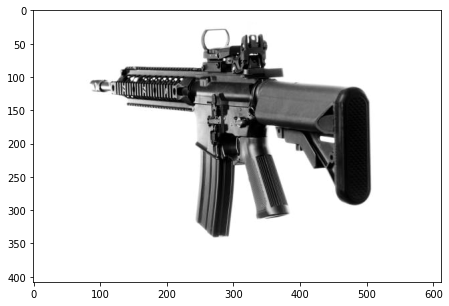

In [ ]:
img = cv2.imread('image_split/train/Assault_Rifle/saldiri_tufek22.jpg',0) #Se viene passato come secondo parametro uno zero legge in scala di grigi, altrimenti RGB
plt.imshow(img, cmap='gray')
plt.show()

## **ANALISI ESPLORATIVE**

In [ ]:
# ANALISI SULLA PRESENZA DI BIANCO (valore 255)

total_number_of_images = 0
for cls in os.listdir('image_split/train'):
  total_number_of_images = total_number_of_images+len(os.listdir(f'image_split/train/{cls}'))

total_array = np.array([])

mean_image = np.zeros((224,224))

width = []
height = []

for cls in tqdm(os.listdir('image_split/train')):
  for image in os.listdir(f'image_split/train/{cls}'):
    img = cv2.imread(f'image_split/train/{cls}/{image}',0)
    height.append(img.shape[0])
    width.append(img.shape[1])
    
    img = center_image(img)
    total_array = np.concatenate((total_array.flatten(), img.flatten()))
    mean_image = mean_image + img/total_number_of_images

100%|██████████| 7/7 [12:51<00:00, 110.23s/it]


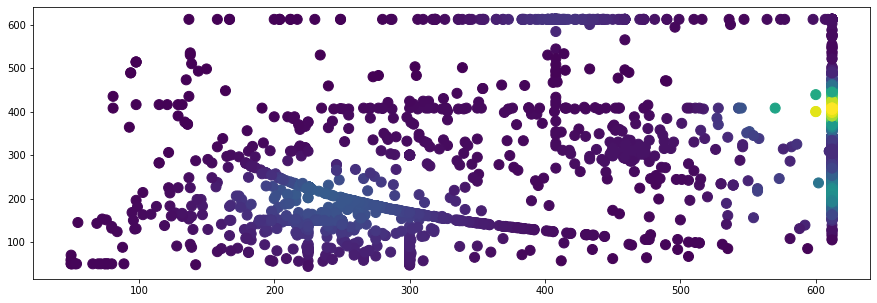

In [ ]:
# Dimensioni originali delle immagini
from scipy.stats import gaussian_kde
xy = np.vstack([width,height])
z = gaussian_kde(xy)(xy)
plt.scatter(width,height, s=100, c=z)
plt.show()

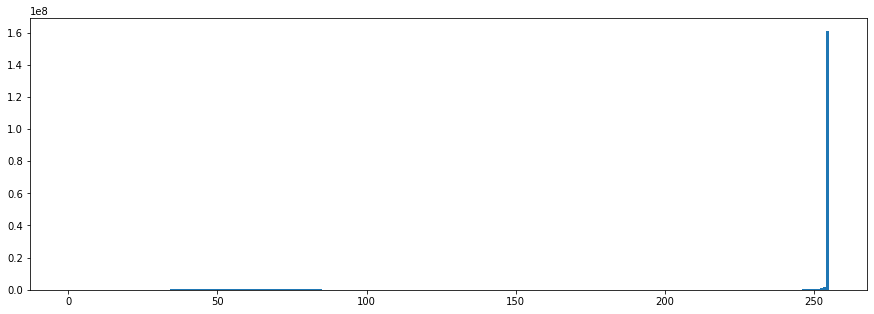

In [ ]:
plt.hist(total_array.flatten(), bins=255)
plt.show()

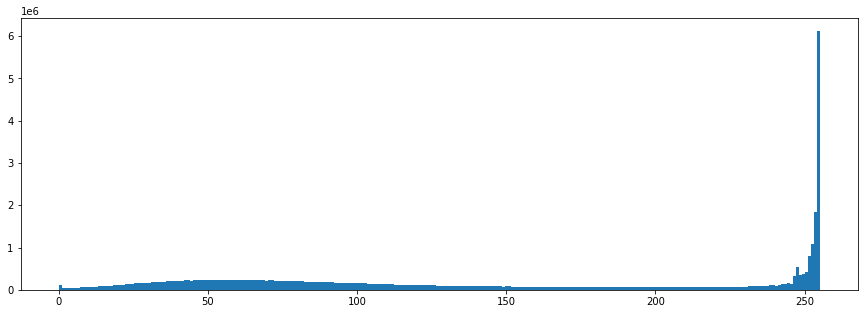

In [ ]:
# Eliminando il colore bianco 

plt.hist(total_array.flatten()[total_array.flatten()!=255], bins=254)
plt.show()

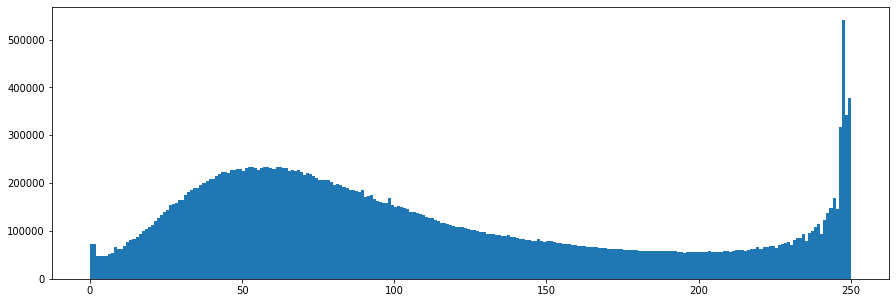

In [ ]:
# Eliminando i bianchi

plt.hist(total_array.flatten()[total_array.flatten()<250], bins=250)
plt.show()

**Visualizzare hist senza bianco**

In [ ]:
pd.Series(total_array).value_counts()/sum(pd.Series(total_array).value_counts())

255.000000    7.899479e-01
254.000000    1.738384e-02
253.000000    3.421039e-03
252.000000    2.349371e-03
251.000000    2.069843e-03
                  ...     
76.892150     5.099756e-09
75.280607     5.099756e-09
69.184326     5.099756e-09
65.630027     5.099756e-09
254.834473    5.099756e-09
Length: 19594560, dtype: float64

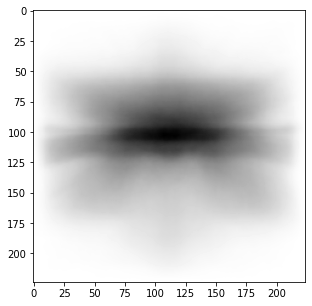

In [ ]:
plt.imshow(mean_image, cmap='gray')
plt.show()

In [ ]:
# ANALISI DI sharpness, luminance, contrast

sharpness = []
luminance = []
contrast = []

for cls in tqdm(os.listdir('image_split/train')):
  for image in os.listdir(f'image_split/train/{cls}'):
    img = cv2.imread(f'image_split/train/{cls}/{image}',0)
    img = center_image(img)
    
    sharpness.append(cv2.Laplacian(img, cv2.CV_64F).var())
    luminance.append(np.mean(img[img!=255]))
    contrast.append(img.std())
    

100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


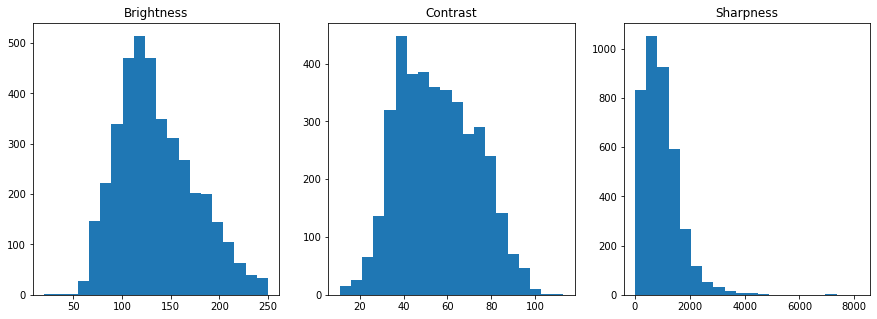

In [ ]:
plt.subplot(1,3,1)
plt.hist(luminance, bins=20)
plt.title('Luminance')

plt.subplot(1,3,2)
plt.hist(contrast, bins=20)
plt.title('Contrast')

plt.subplot(1,3,3)
plt.hist(sharpness, bins=20)
plt.title('Sharpness')

plt.show()

## **DATA AUGMENTATION**

**Centramento e resize di tutto il train e validation**

In [10]:
classes = os.listdir('image')

os.mkdir('train_centered')
os.mkdir('valid_centered')

for cls in tqdm(classes):
  os.mkdir(f'train_centered/{cls}')
  os.mkdir(f'valid_centered/{cls}')
  
  random.seed(123)
  train_idx = random.sample(range(len(os.listdir(f'image_split/train/{cls}'))), int(len(os.listdir(f'image_split/train/{cls}'))*0.75))
  
  for i,image in enumerate(os.listdir(f'image_split/train/{cls}')):
    img = cv2.imread(f'image_split/train/{cls}/{image}')
    img = center_image_rgb(img)
    if i in train_idx:
      cv2.imwrite(f'train_centered/{cls}/{image}', img)
    else:
      cv2.imwrite(f'valid_centered/{cls}/{image}', img)

100%|██████████| 7/7 [00:40<00:00,  5.77s/it]


In [11]:
for cls in classes:
  print(f"train:{len(os.listdir(f'train_centered/{cls}'))} \t valid:{len(os.listdir(f'valid_centered/{cls}'))}")

train:118 	 valid:40
train:657 	 valid:220
train:605 	 valid:202
train:477 	 valid:159
train:521 	 valid:174
train:285 	 valid:95
train:266 	 valid:89


**Augmentation creando versioni ruotate dell'immagine, con variazione della luminanza e l'aggiunta di un quadratino**

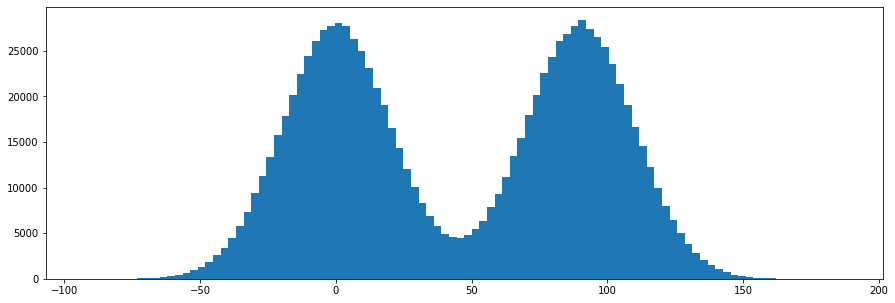

In [12]:
# Distribuzione degli angoli di rotazione che utilizzeremo

x = [np.random.normal(0,20) if np.random.uniform(0,1)>0.5 else np.random.normal(90,20) for i in range(1000000)]
plt.hist(x, bins = 100)
plt.show()

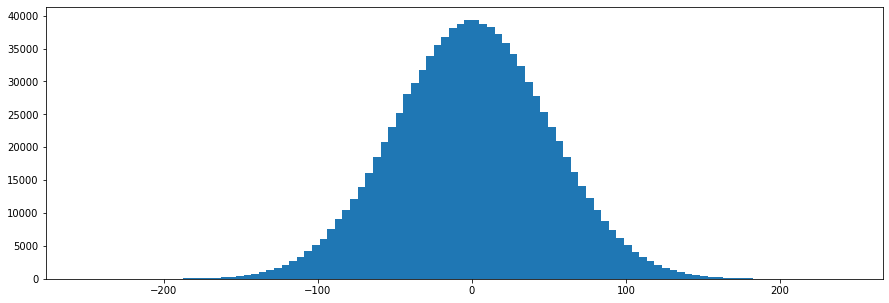

In [13]:
# Distribuzione della variazione di luminanza

plt.hist(np.random.normal(0, 50, 1000000), bins=100)
plt.show()

In [14]:
classes = os.listdir('image')

os.mkdir('train_centered_rotated')

for cls in tqdm(classes):
  os.mkdir(f'train_centered_rotated/{cls}')
  n_rotation = 4000//len(os.listdir(f'train_centered/{cls}'))


  for image in os.listdir(f'train_centered/{cls}'):
    img = cv2.imread(f'train_centered/{cls}/{image}')
    cv2.imwrite(f'train_centered_rotated/{cls}/{image[:-4]}_original.jpg', img)

    angles = [np.random.normal(0,20) if np.random.uniform(0,1)>0.5 else np.random.normal(90,20) for i in range(n_rotation)]
    luminance = np.random.normal(0, 10, n_rotation)

    for i,ang in enumerate(angles):
      rotated = rotate_image(img, ang)
      if np.random.uniform(0,1)<0.2:
        rotated = add_square(rotated)
      rotated = change_luminance(rotated, luminance_lim = int(luminance[i]) if int(luminance[i]) != 0 else 1)
      cv2.imwrite(f'train_centered_rotated/{cls}/{image[:-4]}_rotation{i+1}.jpg', rotated)

100%|██████████| 7/7 [01:39<00:00, 14.25s/it]


In [15]:
# Numerosità originale delle classi
for cls in classes:
  print(len(os.listdir(f'train_centered/{cls}')))


118
657
605
477
521
285
266


In [16]:
# Numerosità nuova delle classi
for cls in classes:
  print(len(os.listdir(f'train_centered_rotated/{cls}')))

4012
4599
4235
4293
4168
4275
4256


In [17]:
# ANALISI SULLA PRESENZA DI BIANCO (valore 255)

total_number_of_images = 0
for cls in os.listdir('train_centered_rotated'):
  total_number_of_images = total_number_of_images+len(os.listdir(f'train_centered_rotated/{cls}'))

mean_image = np.zeros((224,224))

for cls in tqdm(os.listdir('train_centered_rotated')):
  for image in os.listdir(f'train_centered_rotated/{cls}'):
    img = cv2.imread(f'train_centered_rotated/{cls}/{image}',0)
    img = center_image(img)
    mean_image = mean_image + img/total_number_of_images

100%|██████████| 7/7 [00:30<00:00,  4.31s/it]


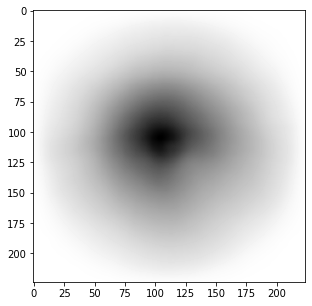

In [18]:
plt.imshow(mean_image, cmap='gray')
plt.show()

Si nota che la data augmentation è servita a rendere le rotazioni delle immagini decisamente più uniformi

## **CLASSIFICATION**

In [19]:
def grafico(cf_matrix, name, labels):
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', square=True)

  ax.set_title(name);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values');

  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

  plt.savefig(name, bbox_inches='tight', pad_inches=0.5)
  copyfile(name, f'gdrive/My Drive/Data_DigitalSignalsProject/confusion_matrix/{name}')

### DATA LOADER

In [20]:
train_not_augmented_path = 'train_centered'
train_path = 'train_centered_rotated'
valid_path = 'valid_centered'

train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

train_not_augmented_dataset = keras.preprocessing.image_dataset_from_directory(train_not_augmented_path,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

val_dataset = keras.preprocessing.image_dataset_from_directory(valid_path,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

Found 29838 files belonging to 7 classes.
Found 2929 files belonging to 7 classes.
Found 979 files belonging to 7 classes.


### RESNET50 ORIGINAL

In [ ]:
RN50 = keras.applications.ResNet50(input_shape=(224,224,3),
                                          weights='imagenet',   #non eredito solo l'architettura, ma anche i pesi 
                                          include_top=False,    #elimino l'ultimo layer denso, questo mappava su 1000 classi
                                          pooling='avg'
                                          )

# Diciamo di non addestrare i layer importati, in modo che addestriamo solo quello che aggiungiamo noi
RN50.trainable = False

num_classes = 7


94765736/94765736 [==============================] - 7s 0us/step


In [ ]:
# Creo una rete che comprende MobileNet, aggiungendo solo un layer denso e il layer di output

inputs = keras.Input((224,224,3)) 

x = inputs

x = keras.applications.resnet.preprocess_input(x) # Dobbiamo effettuare il preprocessing pensato per mobilenetv2, in modo che abbia in input dati adeguati

x = RN50(x)

x = keras.layers.Dense(num_classes, activation='softmax')(x)

outputs = x


original_ResNet50 = keras.Model(inputs, outputs) 
original_ResNet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
____________________________________________

In [ ]:
original_ResNet50.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.RMSprop(learning_rate=0.005),
    metrics = ['accuracy']
)

history_original_ResNet50 = original_ResNet50.fit(train_dataset,
        epochs=10,
        validation_data=val_dataset)

Epoch 1/10
467/467 [==============================] - 114s 220ms/step - loss: 0.1228 - accuracy: 0.9653 - val_loss: 0.0403 - val_accuracy: 0.9898
Epoch 2/10
467/467 [==============================] - 100s 213ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0498 - val_accuracy: 0.9918
Epoch 3/10
467/467 [==============================] - 101s 214ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0398 - val_accuracy: 0.9918
Epoch 4/10
467/467 [==============================] - 100s 212ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0519 - val_accuracy: 0.9898
Epoch 5/10
467/467 [==============================] - 100s 213ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.0597 - val_accuracy: 0.9888
Epoch 6/10
467/467 [==============================] - 100s 212ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0479 - val_accuracy: 0.9908
Epoch 7/10
467/467 [==============================] - 100s 213ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0575 -

In [ ]:
name='original_ResNet50'
joblib.dump(original_ResNet50, f'{name}.sav')
np.save(f'{name}_history.npy', history_original_ResNet50)
copyfile(f'{name}.sav', f'gdrive/My Drive/Data_DigitalSignalsProject/models/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/Data_DigitalSignalsProject/histories/{name}_history.npy')

'gdrive/My Drive/Data_DigitalSignalsProject/histories/original_ResNet50_history.npy'

In [ ]:
%%capture

labels = np.array([])
pred = np.array([])
for x, y in train_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(original_ResNet50.predict(x), axis=-1)])

cf_matrix_original_ResNet50_train = confusion_matrix(labels, pred)


labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(original_ResNet50.predict(x), axis=-1)])

cf_matrix_original_ResNet50 = confusion_matrix(labels, pred)


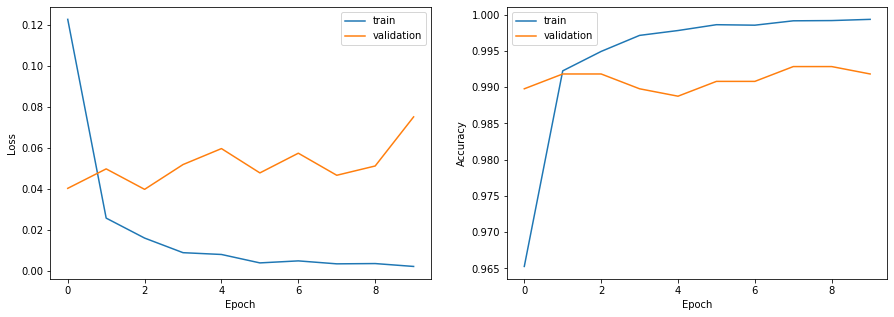

In [ ]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_original_ResNet50.history['loss'])
plt.plot(history_original_ResNet50.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_original_ResNet50.history['accuracy'])
plt.plot(history_original_ResNet50.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

plt.show()

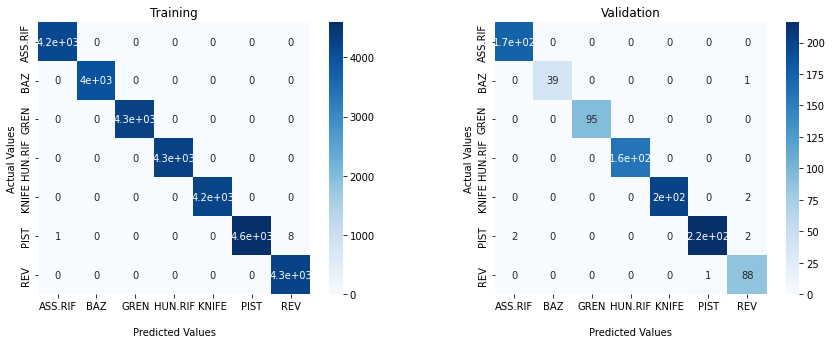

In [ ]:
plt.subplot(1,2,1)
grafico(cf_matrix_original_ResNet50_train, 'cf_original_ResNet50_train.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cf_matrix_original_ResNet50, 'cf_original_ResNet50.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])
plt.title('Validation')

plt.show()

In [ ]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       174
         1.0       1.00      0.97      0.99        40
         2.0       1.00      1.00      1.00        95
         3.0       1.00      1.00      1.00       159
         4.0       1.00      0.99      1.00       202
         5.0       1.00      0.98      0.99       220
         6.0       0.95      0.99      0.97        89

    accuracy                           0.99       979
   macro avg       0.99      0.99      0.99       979
weighted avg       0.99      0.99      0.99       979



### MOBILE NET

In [ ]:
MNv2 = keras.applications.MobileNetV2(input_shape=(224,224,3),
                                          weights='imagenet',   #non eredito solo l'architettura, ma anche i pesi 
                                          include_top=False,    #elimino l'ultimo layer denso, questo mappava su 1000 classi
                                          pooling='avg'
                                          )

# Diciamo di non addestrare i layer importati, in modo che addestriamo solo quello che aggiungiamo noi
MNv2.trainable = False

num_classes = 7


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Creo una rete che comprende MobileNet, aggiungendo solo un layer denso e il layer di output

inputs = keras.Input((224,224,3)) 

x = inputs

x = keras.applications.mobilenet_v2.preprocess_input(x) # Dobbiamo effettuare il preprocessing pensato per mobilenetv2, in modo che abbia in input dati adeguati

x = MNv2(x)

x = keras.layers.Dense(num_classes, activation='softmax')(x)

outputs = x


original_MobileNetV2 = keras.Model(inputs, outputs) 
original_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                             

In [ ]:
original_MobileNetV2.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.RMSprop(learning_rate=0.005),
    metrics = ['accuracy']
)

history_original_MobileNetV2 = original_MobileNetV2.fit(train_dataset,
        epochs=10,
        validation_data=val_dataset)

Epoch 1/10
467/467 [==============================] - 60s 105ms/step - loss: 0.0891 - accuracy: 0.9704 - val_loss: 0.0353 - val_accuracy: 0.9939
Epoch 2/10
467/467 [==============================] - 52s 110ms/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0384 - val_accuracy: 0.9928
Epoch 3/10
467/467 [==============================] - 48s 101ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0360 - val_accuracy: 0.9888
Epoch 4/10
467/467 [==============================] - 45s 96ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0427 - val_accuracy: 0.9928
Epoch 5/10
467/467 [==============================] - 46s 98ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0477 - val_accuracy: 0.9918
Epoch 6/10
467/467 [==============================] - 45s 95ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0494 - val_accuracy: 0.9928
Epoch 7/10
467/467 [==============================] - 45s 95ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0562 - val_accura

In [ ]:
name='original_MobileNetV2'
joblib.dump(original_MobileNetV2, f'{name}.sav')
np.save(f'{name}_history.npy', history_original_MobileNetV2)
copyfile(f'{name}.sav', f'gdrive/My Drive/Data_DigitalSignalsProject/models/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/Data_DigitalSignalsProject/histories/{name}_history.npy')

'gdrive/My Drive/Data_DigitalSignalsProject/histories/original_MobileNetV2_history.npy'

In [ ]:
%%capture

labels = np.array([])
pred = np.array([])
for x, y in train_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(original_MobileNetV2.predict(x), axis=-1)])

cf_matrix_original_MobileNetV2_train = confusion_matrix(labels, pred)


labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(original_MobileNetV2.predict(x), axis=-1)])

cf_matrix_original_MobileNetV2 = confusion_matrix(labels, pred)


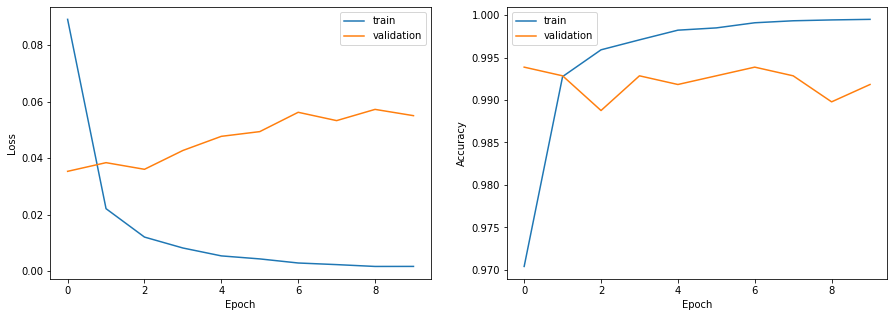

In [ ]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_original_MobileNetV2.history['loss'])
plt.plot(history_original_MobileNetV2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_original_MobileNetV2.history['accuracy'])
plt.plot(history_original_MobileNetV2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

plt.show()

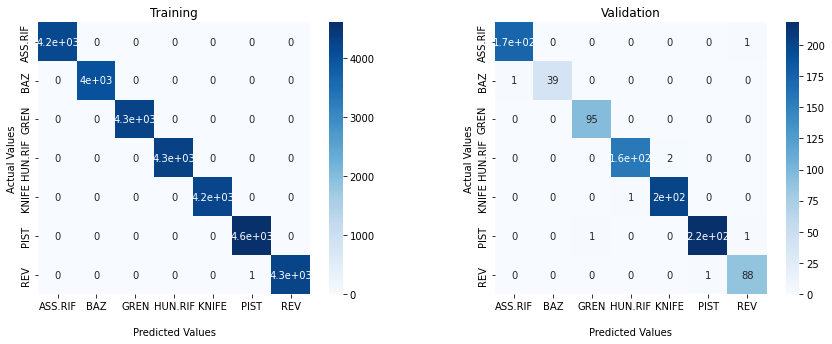

In [ ]:
plt.subplot(1,2,1)
grafico(cf_matrix_original_MobileNetV2_train, 'cf_original_MobileNetV2.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cf_matrix_original_MobileNetV2, 'cf_original_MobileNetV2.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])
plt.title('Validation')

plt.show()

In [ ]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       174
         1.0       1.00      0.97      0.99        40
         2.0       0.99      1.00      0.99        95
         3.0       0.99      0.99      0.99       159
         4.0       0.99      1.00      0.99       202
         5.0       1.00      0.99      0.99       220
         6.0       0.98      0.99      0.98        89

    accuracy                           0.99       979
   macro avg       0.99      0.99      0.99       979
weighted avg       0.99      0.99      0.99       979



### MOBILE NET WITHOUT AUGMENTATION

In [ ]:
MNv2 = keras.applications.MobileNetV2(input_shape=(224,224,3),
                                          weights='imagenet',   #non eredito solo l'architettura, ma anche i pesi 
                                          include_top=False,    #elimino l'ultimo layer denso, questo mappava su 1000 classi
                                          pooling='avg'
                                          )

# Diciamo di non addestrare i layer importati, in modo che addestriamo solo quello che aggiungiamo noi
MNv2.trainable = False

num_classes = 7


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Creo una rete che comprende MobileNet, aggiungendo solo un layer denso e il layer di output

inputs = keras.Input((224,224,3)) 

x = inputs

x = keras.applications.mobilenet_v2.preprocess_input(x) # Dobbiamo effettuare il preprocessing pensato per mobilenetv2, in modo che abbia in input dati adeguati

x = MNv2(x)

x = keras.layers.Dense(num_classes, activation='softmax')(x)

outputs = x


original_MobileNetV2 = keras.Model(inputs, outputs) 
original_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                             

In [ ]:
original_MobileNetV2.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.RMSprop(learning_rate=0.005),
    metrics = ['accuracy']
)

history_original_MobileNetV2 = original_MobileNetV2.fit(train_not_augmented_dataset,
        epochs=10,
        validation_data=val_dataset)

Epoch 1/10
46/46 [==============================] - 19s 188ms/step - loss: 0.2589 - accuracy: 0.9256 - val_loss: 0.1156 - val_accuracy: 0.9632
Epoch 2/10
46/46 [==============================] - 6s 129ms/step - loss: 0.0490 - accuracy: 0.9863 - val_loss: 0.0368 - val_accuracy: 0.9918
Epoch 3/10
46/46 [==============================] - 7s 149ms/step - loss: 0.0262 - accuracy: 0.9921 - val_loss: 0.0582 - val_accuracy: 0.9816
Epoch 4/10
46/46 [==============================] - 6s 131ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0369 - val_accuracy: 0.9877
Epoch 5/10
46/46 [==============================] - 6s 131ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0259 - val_accuracy: 0.9928
Epoch 6/10
46/46 [==============================] - 7s 148ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.0260 - val_accuracy: 0.9908
Epoch 7/10
46/46 [==============================] - 7s 142ms/step - loss: 0.0037 - accuracy: 0.9997 - val_loss: 0.0482 - val_accuracy: 0.9857
Epoch

In [ ]:
name='original_MobileNetV2_without_augmentation'
joblib.dump(original_MobileNetV2, f'{name}.sav')
np.save(f'{name}_history.npy', history_original_MobileNetV2)
copyfile(f'{name}.sav', f'gdrive/My Drive/Data_DigitalSignalsProject/models/{name}.sav')
copyfile(f'{name}_history.npy', f'gdrive/My Drive/Data_DigitalSignalsProject/histories/{name}_history.npy')

In [ ]:
%%capture

labels = np.array([])
pred = np.array([])
for x, y in train_not_augmented_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(original_MobileNetV2.predict(x), axis=-1)])

cf_matrix_original_MobileNetV2_train = confusion_matrix(labels, pred)


labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(original_MobileNetV2.predict(x), axis=-1)])

cf_matrix_original_MobileNetV2 = confusion_matrix(labels, pred)


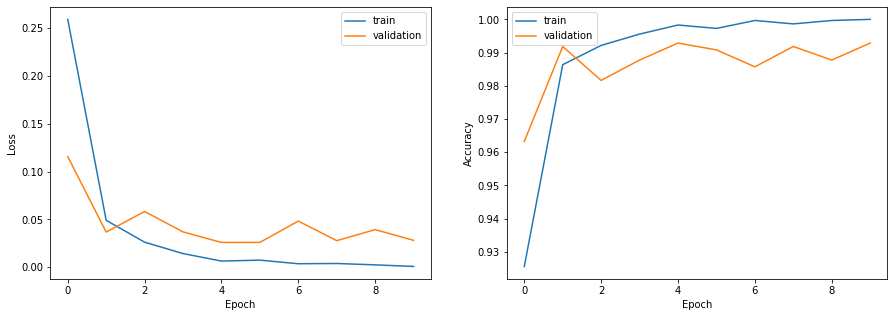

In [ ]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_original_MobileNetV2.history['loss'])
plt.plot(history_original_MobileNetV2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_original_MobileNetV2.history['accuracy'])
plt.plot(history_original_MobileNetV2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

plt.show()

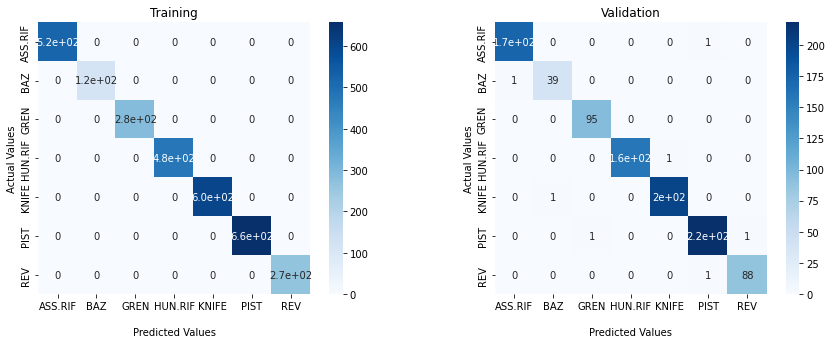

In [ ]:
plt.subplot(1,2,1)
grafico(cf_matrix_original_MobileNetV2_train, 'cf_original_MobileNetV2_train_without_augmentation.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cf_matrix_original_MobileNetV2, 'cf_original_MobileNetV2_without_augmentation.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])
plt.title('Validation')

plt.show()

In [ ]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       174
         1.0       0.97      0.97      0.97        40
         2.0       0.99      1.00      0.99        95
         3.0       1.00      0.99      1.00       159
         4.0       1.00      1.00      1.00       202
         5.0       0.99      0.99      0.99       220
         6.0       0.99      0.99      0.99        89

    accuracy                           0.99       979
   macro avg       0.99      0.99      0.99       979
weighted avg       0.99      0.99      0.99       979



### MOBILE NET RETRAIN

In [ ]:
MNv2_retrain = keras.applications.MobileNetV2(input_shape=(224,224,3),
                                          weights=None,  
                                          include_top=False,
                                          pooling='avg'
                                          )

num_classes = 7


In [ ]:
inputs = keras.Input((224,224,3)) 

x = inputs

x = keras.applications.mobilenet_v2.preprocess_input(x) 

x = MNv2_retrain(x)

x = keras.layers.Dense(512, activation='relu')(x)

x = keras.layers.Dense(num_classes, activation='softmax')(x)

outputs = x


custom_MobileNetV2_retrain = keras.Model(inputs, outputs) 
custom_MobileNetV2_retrain.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                           

In [ ]:
custom_MobileNetV2_retrain.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.RMSprop(learning_rate=0.005),
    metrics = ['accuracy']
)

history_MobileNetV2_retrain = custom_MobileNetV2_retrain.fit(train_dataset,
        epochs=20,
        validation_data=val_dataset)

Epoch 1/20
467/467 [==============================] - 204s 414ms/step - loss: 1.4499 - accuracy: 0.5036 - val_loss: 19.1895 - val_accuracy: 0.2492
Epoch 2/20
467/467 [==============================] - 198s 423ms/step - loss: 0.5774 - accuracy: 0.7906 - val_loss: 67.4994 - val_accuracy: 0.0970
Epoch 3/20
467/467 [==============================] - 198s 424ms/step - loss: 0.3389 - accuracy: 0.8848 - val_loss: 15.7609 - val_accuracy: 0.2778
Epoch 4/20
467/467 [==============================] - 198s 423ms/step - loss: 0.2544 - accuracy: 0.9185 - val_loss: 23.1772 - val_accuracy: 0.0419
Epoch 5/20
467/467 [==============================] - 197s 422ms/step - loss: 0.2038 - accuracy: 0.9356 - val_loss: 25.8373 - val_accuracy: 0.2084
Epoch 6/20
467/467 [==============================] - 197s 422ms/step - loss: 0.1561 - accuracy: 0.9508 - val_loss: 12.8755 - val_accuracy: 0.2441
Epoch 7/20
467/467 [==============================] - 198s 424ms/step - loss: 0.1373 - accuracy: 0.9566 - val_loss: 11

In [ ]:
%%capture
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(custom_MobileNetV2_retrain.predict(x), axis=-1)])

cf_matrix_MobileNetV2_retrain = confusion_matrix(labels, pred)


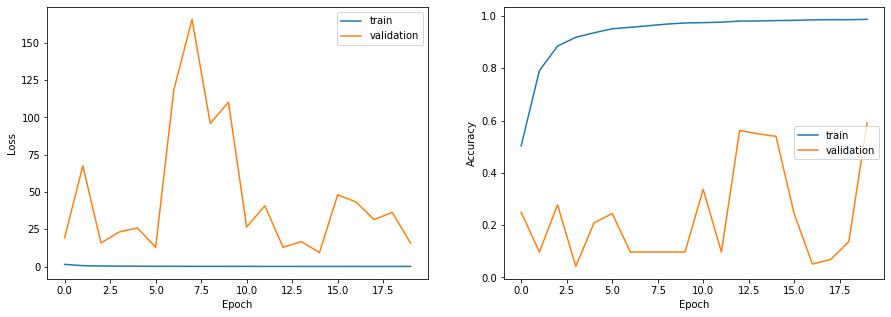

In [ ]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_MobileNetV2_retrain.history['loss'])
plt.plot(history_MobileNetV2_retrain.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_MobileNetV2_retrain.history['accuracy'])
plt.plot(history_MobileNetV2_retrain.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

plt.show()

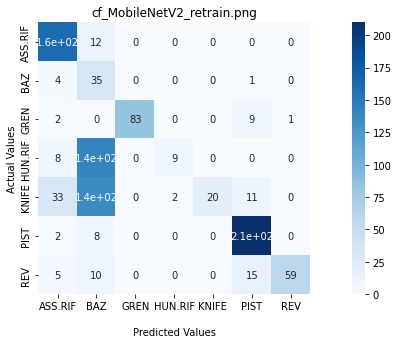

In [ ]:
grafico(cf_matrix_MobileNetV2_retrain, 'cf_MobileNetV2_retrain.png', ['ASS.RIF','BAZ','GREN','HUN.RIF','KNIFE','PIST','REV'])

In [ ]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83       174
         1.0       0.10      0.88      0.18        40
         2.0       1.00      0.87      0.93        95
         3.0       0.82      0.06      0.11       159
         4.0       1.00      0.10      0.18       202
         5.0       0.85      0.95      0.90       220
         6.0       0.98      0.66      0.79        89

    accuracy                           0.59       979
   macro avg       0.79      0.64      0.56       979
weighted avg       0.85      0.59      0.57       979



### MOBILE NET USATA COME FEATURE EXTRACTOR

In [21]:
MNv2 = keras.applications.MobileNetV2(input_shape=(224,224,3),
                                          weights='imagenet',   #non eredito solo l'architettura, ma anche i pesi 
                                          include_top=False,    #elimino l'ultimo layer denso, questo mappava su 1000 classi
                                          pooling='avg'
                                          )

9406464/9406464 [==============================] - 0s 0us/step


In [22]:
def neural_features(image):
  array = keras.preprocessing.image.img_to_array(image)
  array_prep = keras.applications.mobilenet_v2.preprocess_input(array)
  array_4d = np.expand_dims(array_prep, axis=0)
  features = MNv2.predict(array_4d, verbose=False)
  return features.flatten()

In [33]:
def load_data(feature_extractor=neural_features, base_path=0):

    paths = []
    features = []

    for fi,f in enumerate(sorted(os.listdir(base_path))):
        if f.endswith('.jpg'):
            # Save file path
            cur_path = base_path + f
            paths.append(cur_path)
            
            # Load file and extract features
            image = kimage2.load_img(cur_path, target_size=(224, 224))
            cur_features = feature_extractor(image)
            features.append(cur_features)

    features = np.array(features)
    return features, paths

In [ ]:
classes

['Revolver',
 'Hunting_Rifle',
 'Bazooka',
 'Grenade',
 'Knife',
 'Pistol',
 'Assault_Rifle']

In [ ]:
X_train = []
y_train = []
names_list_train = []

X_valid = []
y_valid = []
names_list_valid = []

for i, cls in enumerate(classes):
  print('Train')
  print(f'-----> {cls}')
  X, names = load_data(feature_extractor=neural_features, base_path=f'train_centered_rotated/{cls}/')
  if i==0:
    X_train = X
    y_train = np.repeat(i, len(X))
    names_list = names
  else:
    X_train = np.concatenate((X_train, X), axis=0)
    y_train = np.concatenate((y_train, np.repeat(i, len(X))))
    names_list_train = np.concatenate((names_list_train, names))


for i, cls in enumerate(classes):
  print('Valid')
  print(f'-----> {cls}')
  X, names = load_data(feature_extractor=neural_features, base_path=f'valid_centered/{cls}/')
  if i==0:
    X_valid = X
    y_valid = np.repeat(i, len(X))
    names_list_valid = names
  else:
    X_valid = np.concatenate((X_valid, X), axis=0)
    y_valid = np.concatenate((y_valid, np.repeat(i, len(X))))
    names_list_valid = np.concatenate((names_list_valid, names))

In [ ]:
with open('X_train.npy', 'wb') as f:
    np.save(f, X_train)
copyfile('X_train.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/X_train.npy')

with open('y_train.npy', 'wb') as f:
    np.save(f, y_train)
copyfile('y_train.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/y_train.npy')

with open('names_train.npy', 'wb') as f:
    np.save(f, names_list_train)
copyfile('names_train.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/names_train.npy')



with open('X_valid.npy', 'wb') as f:
    np.save(f, X_valid)
copyfile('X_valid.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/X_valid.npy')

with open('y_valid.npy', 'wb') as f:
    np.save(f, y_valid)
copyfile('y_valid.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/y_valid.npy')

with open('names_valid.npy', 'wb') as f:
    np.save(f, names_list_valid)
copyfile('names_valid.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/names_valid.npy')

'gdrive/MyDrive/Data_DigitalSignalsProject/names_valid.npy'

In [ ]:
print(len(X_train), len(y_train))
print(len(X_valid), len(y_valid))

29838 29838
979 979


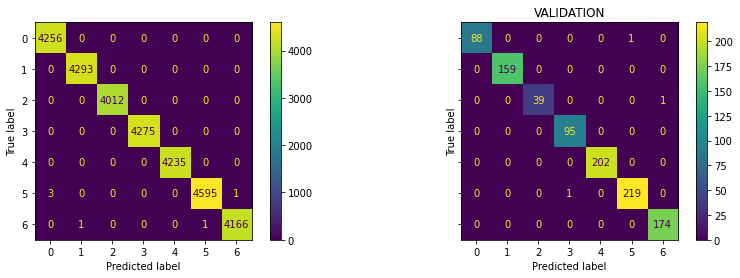

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = SVC()


clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=clf.classes_)


y_pred_valid = clf.predict(X_valid)
cm_valid = confusion_matrix(y_valid, y_pred_valid)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_valid,
                              display_labels=clf.classes_)

f, axes = plt.subplots(1, 2, figsize=(14, 4), sharey='row')
disp_train.plot(ax=axes[0])
plt.title('TRAINING')

disp_test.plot(ax=axes[1])
plt.title('VALIDATION')

plt.savefig('feature_extraction.jpg', bbox_inches='tight', pad_inches=0.5)
copyfile('feature_extraction.jpg', f'gdrive/My Drive/Data_DigitalSignalsProject/confusion_matrix/feature_extraction.jpg')

plt.show()

In [ ]:
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       1.00      1.00      1.00       159
           2       1.00      0.97      0.99        40
           3       0.99      1.00      0.99        95
           4       1.00      1.00      1.00       202
           5       1.00      1.00      1.00       220
           6       0.99      1.00      1.00       174

    accuracy                           1.00       979
   macro avg       1.00      0.99      1.00       979
weighted avg       1.00      1.00      1.00       979



# **TEST**


In [ ]:
X_train_valid = []
y_train_valid = []
names_list_train_valid = []

for i, cls in enumerate(classes):
  print('Train')
  print(f'-----> {cls}')
  X, names = load_data(feature_extractor=neural_features, base_path=f'train_centered_rotated/{cls}/')
  if i==0:
    X_train_valid = X
    y_train_valid = np.repeat(i, len(X))
    names_list_train_valid = names
  else:
    X_train_valid = np.concatenate((X_train_valid, X), axis=0)
    y_train_valid = np.concatenate((y_train_valid, np.repeat(i, len(X))))
    names_list_train_valid = np.concatenate((names_list_train_valid, names))


for i, cls in enumerate(classes):
  print('Valid')
  print(f'-----> {cls}')
  X, names = load_data(feature_extractor=neural_features, base_path=f'valid_centered/{cls}/')
  X_train_valid = np.concatenate((X_train_valid, X), axis=0)
  y_train_valid = np.concatenate((y_train_valid, np.repeat(i, len(X))))
  names_list_train_valid = np.concatenate((names_list_train_valid, names))

In [ ]:
with open('X_train_valid.npy', 'wb') as f:
    np.save(f, X_train_valid)
copyfile('X_train_valid.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/X_train_valid.npy')

with open('y_train_valid.npy', 'wb') as f:
    np.save(f, y_train_valid)
copyfile('y_train_valid.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/y_train_valid.npy')

with open('names_train_valid.npy', 'wb') as f:
    np.save(f, names_list_train_valid)
copyfile('names_train_valid.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/names_train_valid.npy')

'gdrive/MyDrive/Data_DigitalSignalsProject/names_train_valid.npy'

In [ ]:
os.mkdir('test_centered')

for cls in tqdm(classes):
  os.mkdir(f'test_centered/{cls}')
  for i,image in enumerate(os.listdir(f'image_split/test/{cls}')):
    img = cv2.imread(f'image_split/test/{cls}/{image}')
    img = center_image_rgb(img)
    cv2.imwrite(f'test_centered/{cls}/{image}', img)


100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


In [ ]:
X_test = []
y_test = []
names_list_test = []

for i, cls in enumerate(classes):
  print('Test')
  print(f'-----> {cls}')
  X, names = load_data(feature_extractor=neural_features, base_path=f'test_centered/{cls}/')
  if i==0:
    X_test = X
    y_test = np.repeat(i, len(X))
    names_list_test = names
  else:
    X_test = np.concatenate((X_test, X), axis=0)
    y_test = np.concatenate((y_test, np.repeat(i, len(X))))
    names_list_test = np.concatenate((names_list_test, names))

Test
-----> Revolver
Test
-----> Hunting_Rifle
Test
-----> Bazooka
Test
-----> Grenade
Test
-----> Knife
Test
-----> Pistol
Test
-----> Assault_Rifle


In [ ]:
with open('X_test.npy', 'wb') as f:
    np.save(f, X_test)
copyfile('X_test.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/X_test.npy')

with open('y_test.npy', 'wb') as f:
    np.save(f, y_test)
copyfile('y_test.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/y_test.npy')

with open('names_test.npy', 'wb') as f:
    np.save(f, names_list_test)
copyfile('names_test.npy', 'gdrive/MyDrive/Data_DigitalSignalsProject/names_test.npy')

In [ ]:
print(len(X_train_valid), len(y_train_valid))
print(len(X_test), len(y_test))

30817 30817
1306 1306


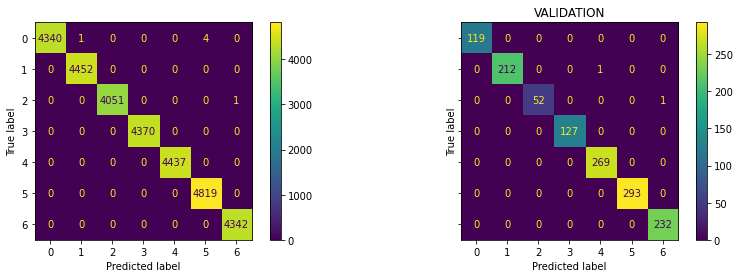

In [ ]:
clf = SVC()

clf.fit(X_train_valid, y_train_valid)
y_pred = clf.predict(X_train_valid)
cm_train = confusion_matrix(y_train_valid, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=clf.classes_)


y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=clf.classes_)

f, axes = plt.subplots(1, 2, figsize=(14, 4), sharey='row')
disp_train.plot(ax=axes[0])
plt.title('TRAINING')

disp_test.plot(ax=axes[1])
plt.title('VALIDATION')

plt.savefig('feature_extraction_final_test.jpg', bbox_inches='tight', pad_inches=0.5)
copyfile('feature_extraction_final_test.jpg', f'gdrive/My Drive/Data_DigitalSignalsProject/confusion_matrix/feature_extraction_final_test.jpg')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       213
           2       1.00      0.98      0.99        53
           3       1.00      1.00      1.00       127
           4       1.00      1.00      1.00       269
           5       1.00      1.00      1.00       293
           6       1.00      1.00      1.00       232

    accuracy                           1.00      1306
   macro avg       1.00      1.00      1.00      1306
weighted avg       1.00      1.00      1.00      1306



In [ ]:
joblib.dump(clf, 'image_classifier_model.sav')
copyfile('image_classifier_model.sav', 'gdrive/MyDrive/Data_DigitalSignalsProject/image_classifier_model.sav')